# Learning to stabilize a linear system

For this example we demonstrate learning to stabilize a double integrator system using [Differentiable predictive control (DPC) method](https://www.sciencedirect.com/science/article/pii/S0959152422000981). 

**Differentiable Predictive Control method**:  
The DPC is a model-based policy optimization algorithm, that exploits the differentiability of a wide class of model representations for dynamical systems, including differential equations, state-space models, or various neural network architectures. In DPC, we construct a differentiable closed-loop system composed of neural control policy and system dynamics model that is to be optimized using parametric control objectives as intrinsic reward signals evaluated over a sampled distribution of the problem parameters.

<img src="./figs/DPC_simple_method.png" width="600">  

## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

We need to install a more recent version of matplotlib than is offered in the default Colab environment. After running the cell 1 for the first time in a new Colab runtime, you will see the prompt: "You must restart the runtime in order to use newly installed versions." After restarting, the correct version of matplotlib will be loaded for the duration of the current runtime.

In [ ]:
!pip install setuptools==61.0.0 casadi mlflow torchdiffeq dill pyts plum-dispatch==1.7.3 --user
!pip install git+https://github.com/pnnl/neuromancer.git@master --ignore-requires-python --no-deps --user

In [1]:
import torch
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.plot import pltCL, pltPhase

# Node and System classes

The Node class is a simple wrapper for any callable pytorch function or nn.Module which provides names for the inputs and outputs to be used in composition of a potentially cyclic computational graph.  

In [2]:
# Double integrator parameters
nx = 2
nu = 1
A = torch.tensor([[1.2, 1.0],
                  [0.0, 1.0]])
B = torch.tensor([[1.0],
                  [0.5]])

# linear state space model
xnext = lambda x, u: x @ A.T + u @ B.T    
double_integrator = Node(xnext, ['X', 'U'], ['X'], name='integrator')

# neural control policy
mlp = blocks.MLP(nx, nu, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ReLU,
                 hsizes=[20, 20, 20, 20])
policy = Node(mlp, ['X'], ['U'], name='policy')

# closed loop system definition
cl_system = System([policy, double_integrator])
# cl_system.show()

# Training dataset generation

For a training dataset we randomly sample points away from the origin of the 2D space the systemn operates in. 

In [3]:
# Training dataset generation
train_data = DictDataset({'X': 3.*torch.randn(3333, 1, nx)}, name='train')  # Split conditions into train and dev
dev_data = DictDataset({'X': 3.*torch.randn(3333, 1, nx)}, name='dev')
train_loader = torch.utils.data.DataLoader(train_data, batch_size=3333,
                                           collate_fn=train_data.collate_fn, shuffle=False)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=3333,
                                         collate_fn=dev_data.collate_fn, shuffle=False)

# Optimization problem

We want to learn a controller that stabilizes the double integrator system. In other words we would like a control policy that pushes the system to stay at the origin. 

In [4]:
# Define optimization problem
u = variable('U')
x = variable('X')
action_loss = 0.001 * (u == 0.)^2  # control penalty
regulation_loss = 10. * (x == 0.)^2  # target position
loss = PenaltyLoss([action_loss, regulation_loss], [])
problem = Problem([cl_system], loss)
optimizer = torch.optim.AdamW(policy.parameters(), lr=0.001)

# Optimize problem with a system rollout of 2 time steps


In [5]:
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    dev_loader,
    optimizer=optimizer,
    epochs=400,
    train_metric="train_loss",
    dev_metric="dev_loss",
    eval_metric='dev_loss',
    warmup=400,
)

# Train model with prediction horizon of 2
cl_system.nsteps = 2
best_model = trainer.train()

C:\Users\drgo694\OneDrive - PNNL\Documents\Codes_dev\neuromancer\neuromancer\src\neuromancer\constraint.py:163: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([3333, 2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(left, right)
C:\Users\drgo694\OneDrive - PNNL\Documents\Codes_dev\neuromancer\neuromancer\src\neuromancer\constraint.py:163: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([3333, 3, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(left, right)


epoch: 0  train_loss: 193.5588836669922
epoch: 1  train_loss: 192.9071044921875
epoch: 2  train_loss: 192.24745178222656
epoch: 3  train_loss: 191.58267211914062
epoch: 4  train_loss: 190.90855407714844
epoch: 5  train_loss: 190.22085571289062
epoch: 6  train_loss: 189.51451110839844
epoch: 7  train_loss: 188.78616333007812
epoch: 8  train_loss: 188.0347900390625
epoch: 9  train_loss: 187.25958251953125
epoch: 10  train_loss: 186.459716796875
epoch: 11  train_loss: 185.6305694580078
epoch: 12  train_loss: 184.76751708984375
epoch: 13  train_loss: 183.86732482910156
epoch: 14  train_loss: 182.9285888671875
epoch: 15  train_loss: 181.95050048828125
epoch: 16  train_loss: 180.93272399902344
epoch: 17  train_loss: 179.8739776611328
epoch: 18  train_loss: 178.77410888671875
epoch: 19  train_loss: 177.63369750976562
epoch: 20  train_loss: 176.4532928466797
epoch: 21  train_loss: 175.2333221435547
epoch: 22  train_loss: 173.97215270996094
epoch: 23  train_loss: 172.66761779785156
epoch: 24  t

epoch: 197  train_loss: 39.5925178527832
epoch: 198  train_loss: 39.59073257446289
epoch: 199  train_loss: 39.58898162841797
epoch: 200  train_loss: 39.58726501464844
epoch: 201  train_loss: 39.58557891845703
epoch: 202  train_loss: 39.58390808105469
epoch: 203  train_loss: 39.58228302001953
epoch: 204  train_loss: 39.5806770324707
epoch: 205  train_loss: 39.579097747802734
epoch: 206  train_loss: 39.57756042480469
epoch: 207  train_loss: 39.576053619384766
epoch: 208  train_loss: 39.57457733154297
epoch: 209  train_loss: 39.573123931884766
epoch: 210  train_loss: 39.57168960571289
epoch: 211  train_loss: 39.570281982421875
epoch: 212  train_loss: 39.568904876708984
epoch: 213  train_loss: 39.567535400390625
epoch: 214  train_loss: 39.56619644165039
epoch: 215  train_loss: 39.564876556396484
epoch: 216  train_loss: 39.563575744628906
epoch: 217  train_loss: 39.562294006347656
epoch: 218  train_loss: 39.56103515625
epoch: 219  train_loss: 39.55980682373047
epoch: 220  train_loss: 39.558

epoch: 392  train_loss: 39.485355377197266
epoch: 393  train_loss: 39.48522186279297
epoch: 394  train_loss: 39.48509216308594
epoch: 395  train_loss: 39.48496627807617
epoch: 396  train_loss: 39.48483657836914
epoch: 397  train_loss: 39.484710693359375
epoch: 398  train_loss: 39.48458480834961
epoch: 399  train_loss: 39.484458923339844


# Evaluate best model on a system rollout 


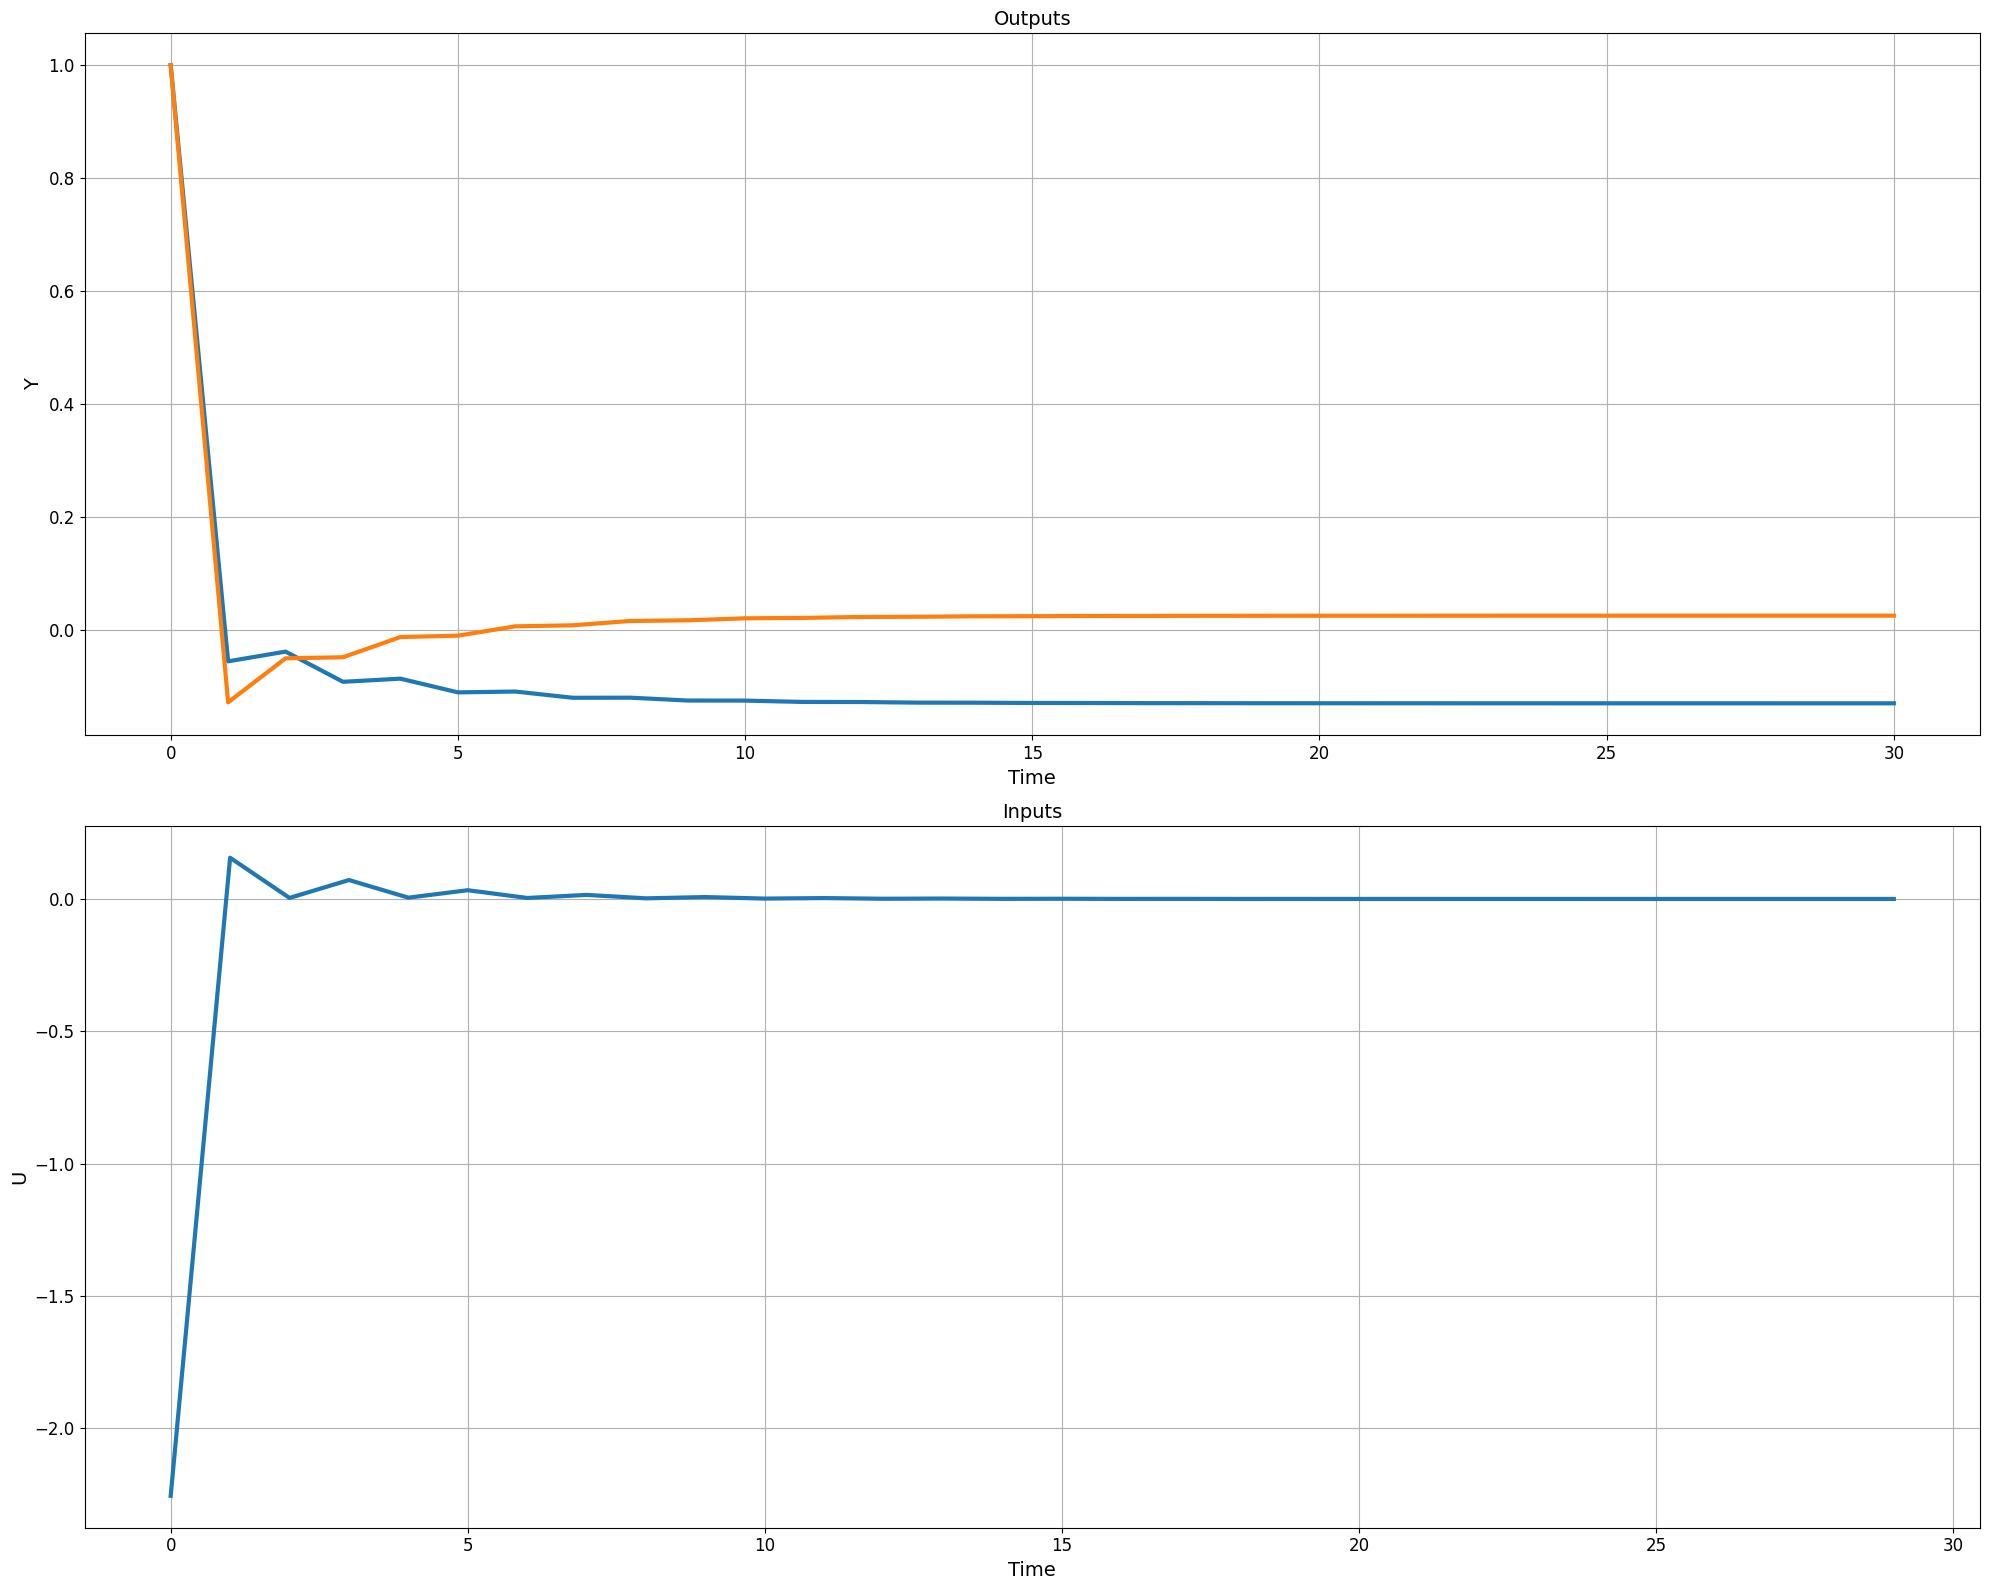

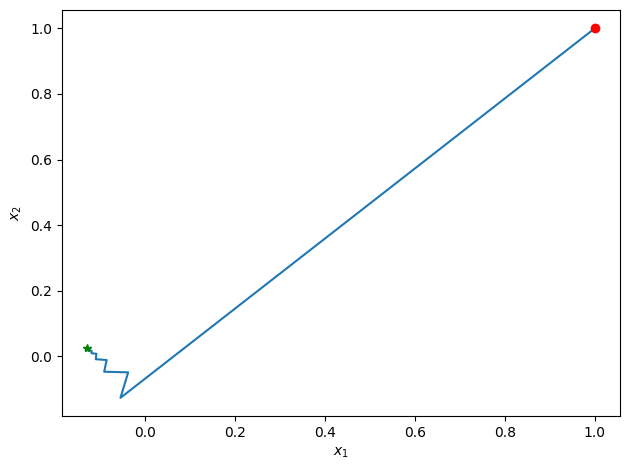

<Figure size 640x480 with 0 Axes>

In [7]:
# Test best model with prediction horizon of 50
problem.load_state_dict(best_model)
data = {'X': torch.ones(1, 1, nx, dtype=torch.float32)}
nsteps = 30
cl_system.nsteps = nsteps
trajectories = cl_system(data)
pltCL(Y=trajectories['X'].detach().reshape(nsteps+1, 2), U=trajectories['U'].detach().reshape(nsteps, 1), figname='cl.png')
pltPhase(X=trajectories['X'].detach().reshape(nsteps+1, 2), figname='phase.png')